In [1]:
import sys
print("Using Python from:", sys.executable)

Using Python from: c:\Users\Lenovo\Downloads\YOLO pose detection\venv\Scripts\python.exe


In [13]:
#!/usr/bin/env python
# coding: utf-8

# # Exploratory Data Analysis (EDA) for Sitting Posture Dataset

# ---
# ## 1. Import Libraries & Load Data
# ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform, randint
# Load dataset
df = pd.read_csv("dataset.csv")  # change path if needed



df=df.drop(columns=['shoulder_hip_distance','timestamp'], )
# Preview
df.head()


,head_forward_x,head_forward_y,neck_angle,spine_tilt,shoulder_forward_offset,hip_tilt,trunk_to_hip_angle,torso_lean_x,torso_lean_y,com_shift_x,label
0,0.162,-0.751,1.568,-1.551,0.019,-3.103,1.360,0.019,-0.978,0.009,neutral
1,0.106,-0.699,1.650,-1.498,0.073,-3.099,1.329,0.073,-0.994,0.036,neutral
2,0.105,-0.707,1.636,-1.495,0.075,-3.099,1.332,0.075,-0.988,0.037,neutral
3,0.091,-0.706,1.646,-1.448,0.115,-3.053,1.317,0.115,-0.933,0.057,neutral
4,0.085,-0.717,1.661,-1.489,0.080,-3.099,1.321,0.080,-0.973,0.040,neutral


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_36420\3850659411.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="Set2")


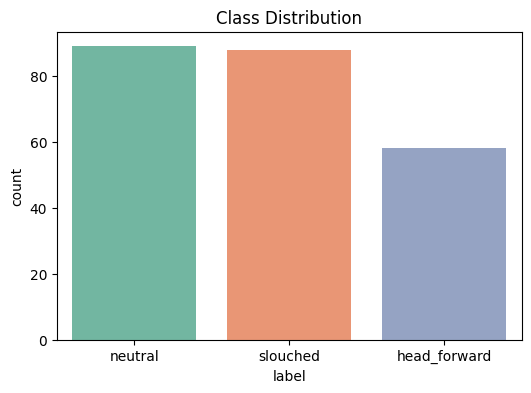

label
neutral         37.872340
slouched        37.446809
head_forward    24.680851
Name: proportion, dtype: float64

In [3]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="label", palette="Set2")
plt.title("Class Distribution")
plt.show()

df["label"].value_counts(normalize=True) * 100

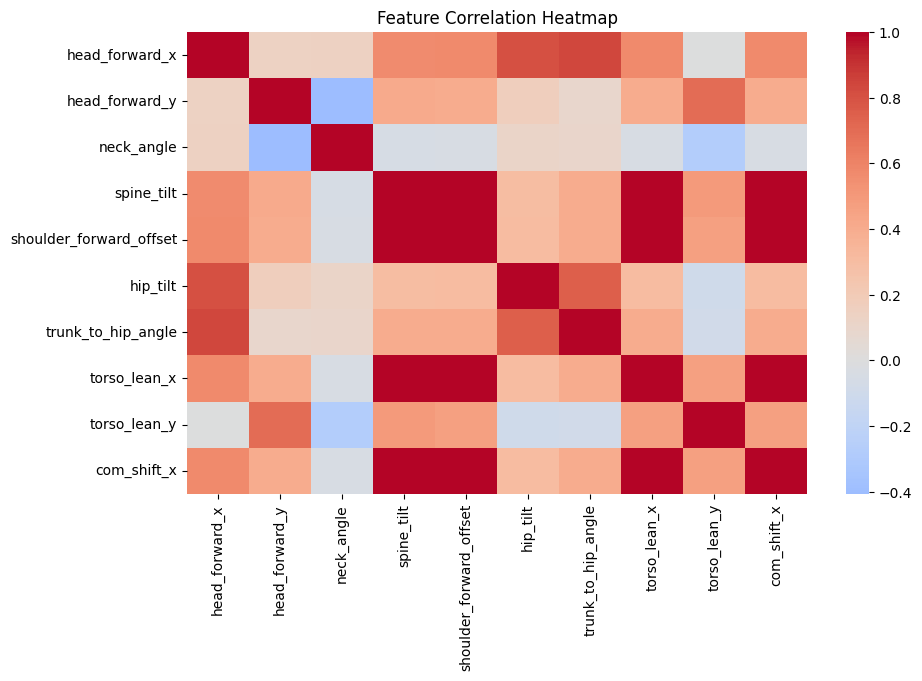

In [4]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
# Drop non-feature columns
X = df.drop(columns=["label"])
y = df["label"]

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [17]:
# Train XGBoost
xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=len(encoder.classes_),
    eval_metric="mlogloss",
    random_state=42
)


In [ ]:
param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3),   # continuous range
    "subsample": uniform(0.7, 0.3),        # 0.7 to 1.0
    "colsample_bytree": uniform(0.7, 0.3)  # 0.7 to 1.0
}


In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,              # number of random combinations to try
    scoring="accuracy",
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)
random_search.fit(X, y_encoded)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,estimator,"XGBClassifier..._class=3, ...)"
,param_distributions,"{'colsample_bytree': <scipy.stats....00127995345D0>, 'learning_rate': <scipy.stats....0012799534510>, 'max_depth': <scipy.stats....001279685DDD0>, 'n_estimators': <scipy.stats....0012798B5FB90>, ...}"
,n_iter,30
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [21]:
print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

Best Parameters: {'colsample_bytree': np.float64(0.76553213116505), 'learning_rate': np.float64(0.13495298436110986), 'max_depth': 8, 'n_estimators': 430, 'subsample': np.float64(0.7973035063015821)}
Best CV Score: 0.8978723404255318


In [22]:
best_model = random_search.best_estimator_

# 📌 Cell 8: Final Evaluation (on full dataset)
y_pred = best_model.predict(X)
print("\nClassification Report:\n", classification_report(y_encoded, y_pred, target_names=encoder.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_encoded, y_pred))


Classification Report:
               precision    recall  f1-score   support

head_forward       1.00      1.00      1.00        58
     neutral       1.00      1.00      1.00        89
    slouched       1.00      1.00      1.00        88

    accuracy                           1.00       235
   macro avg       1.00      1.00      1.00       235
weighted avg       1.00      1.00      1.00       235


Confusion Matrix:
 [[58  0  0]
 [ 0 89  0]
 [ 0  0 88]]


Train size: 164
Validation size: 35
Test size: 36


c:\Users\Lenovo\Downloads\YOLO pose detection\posture_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:38:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Validation Performance:

              precision    recall  f1-score   support

head_forward       0.67      0.67      0.67         9
     neutral       0.92      0.85      0.88        13
    slouched       0.86      0.92      0.89        13

    accuracy                           0.83        35
   macro avg       0.81      0.81      0.81        35
weighted avg       0.83      0.83      0.83        35


📊 Test Performance:

              precision    recall  f1-score   support

head_forward       0.67      0.75      0.71         8
     neutral       0.88      1.00      0.93        14
    slouched       0.82      0.64      0.72        14

    accuracy                           0.81        36
   macro avg       0.79      0.80      0.79        36
weighted avg       0.81      0.81      0.80        36



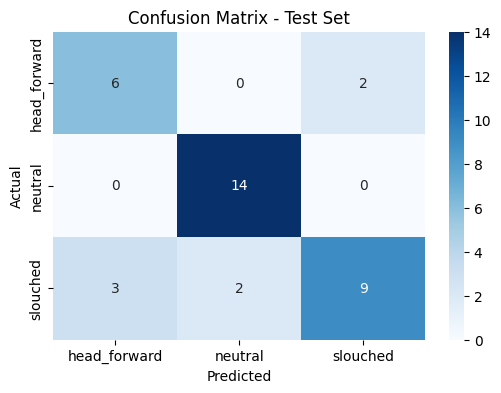

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.30, stratify=y_encoded, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])

# 📌 Train model with best params
best_params = {
    'colsample_bytree': 0.76553213116505,
    'learning_rate': 0.13495298436110986,
    'max_depth': 8,
    'n_estimators': 430,
    'subsample': 0.7973035063015821
}

best_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",
    objective="multi:softprob",
    random_state=42,
    **best_params
)

best_model.fit(X_train, y_train)

# 📌 Evaluate on validation set
y_val_pred = best_model.predict(X_val)
print("\n📊 Validation Performance:\n")
print(classification_report(y_val, y_val_pred, target_names=encoder.classes_))

# 📌 Evaluate on test set
y_test_pred = best_model.predict(X_test)
print("\n📊 Test Performance:\n")
print(classification_report(y_test, y_test_pred, target_names=encoder.classes_))

# 📌 Confusion Matrix (Test)
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.show()

In [25]:
new_sample = pd.DataFrame([{
    "head_forward_x": -0.307,
    "head_forward_y": -0.297,
    "neck_angle": 0.917,
    "spine_tilt": -1.701,
    "shoulder_hip_distance": 1.0,
    "shoulder_forward_offset": -0.128,
    "hip_tilt": -3.039,
    "trunk_to_hip_angle": 0.994,
    "torso_lean_x": -0.128,
    "torso_lean_y": -0.982,
    "com_shift_x": -0.064,
    "label": "head_forward",        # actual label (for checking)
    "timestamp": 1758953799351
}])

# === Drop non-feature columns ===
X_new = new_sample.drop(columns=["label", "timestamp","shoulder_hip_distance"])

# === Predict with trained best_model ===
y_pred_encoded = best_model.predict(X_new)[0]
y_pred_label = encoder.inverse_transform([y_pred_encoded])[0]

print("✅ Predicted Label:", y_pred_label)
print("🎯 Actual Label:", new_sample["label"].iloc[0])

✅ Predicted Label: head_forward
🎯 Actual Label: head_forward


In [26]:
import joblib

# Save model + encoder
joblib.dump(best_model, "xgb_posture_model.pkl")
joblib.dump(encoder, "label_encoder.pkl")

# Later: Load model + encoder
loaded_model = joblib.load("xgb_posture_model.pkl")
loaded_encoder = joblib.load("label_encoder.pkl")

# Test
y_pred = loaded_model.predict(X_new)
print("Predicted:", loaded_encoder.inverse_transform(y_pred))

Predicted: ['head_forward']
